# IMPORTING LIBRARIES

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score  




# EXTRACTING THE DATA

In [63]:
gen1 = pd.read_csv(r'C:\Users\Karahan C\Desktop\Bitirme\Data\Plant_1_Generation_Data.csv') # SOLAR GENARTION DATA
whet1 = pd.read_csv(r'C:\Users\Karahan C\Desktop\Bitirme\Data\Plant_1_Weather_Sensor_Data.csv') # WHEATHER DATA

## LET'S SEE WHAT WE HAVE ON THE DATA SET

In [64]:
gen1.info()
gen1.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0
68777,17-06-2020 23:45,4135001,zVJPv84UY57bAof,0.0,0.0,5910.000,7363272.0


In [65]:
print(gen1.isna().sum())
print(gen1.isnull().sum())
print(f'Unique number of inverters: {np.count_nonzero(gen1["SOURCE_KEY"].unique())}')
print(f'Unique number of plants: {np.count_nonzero(gen1["PLANT_ID"].unique())}')

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
Unique number of inverters: 22
Unique number of plants: 1


gen1 dataframe(df) doesn't contain any null data. Also there are 22 unique inverters and data gathered from same solar power plant.


In [66]:
print(whet1.info())
print(whet1.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB
None
                DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
271   2020-05-17 22:30:00   4135001  HmiyD2TTLFNqkNe            21.314433   
2498  2020-06-10 21:00:00   4135001  HmiyD2TTLFNqkNe            22.296842   
366   2020-05-18 22:15:00   4135001  HmiyD2TTLFNqkNe            22.913321   
670   2020-05-22 14:00:00   4135001  HmiyD2TTLFNqkNe            31.882248   
856   2020-05-24 14:00:00   4135001  Hmi

In [67]:
print(whet1.isna().sum())
print(whet1.isnull().sum())
print(f'Unique number of source: {np.count_nonzero(whet1["SOURCE_KEY"].unique())}')
print(f'Unique number of plants: {np.count_nonzero(whet1["PLANT_ID"].unique())}')

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64
Unique number of source: 1
Unique number of plants: 1


There are no null data in the whet1 df.

In [68]:
# DATE_TIME OBJECT CONVERTED TO datetime64 FOR USING IN TIME-SERIES ANALYSIS
gen1['DATE_TIME'] = pd.to_datetime(gen1['DATE_TIME'], dayfirst=True)
whet1['DATE_TIME'] = pd.to_datetime(whet1['DATE_TIME'], dayfirst=True)


gen1['DATE'] = pd.to_datetime(gen1['DATE_TIME'],format='%d-%m-%Y %H:%M').dt.date
gen1['TIME'] = pd.to_datetime(gen1['DATE_TIME'],format='%d-%m-%Y %H:%M').dt.time
gen1['HOUR'] = pd.to_datetime(gen1['DATE_TIME'],format='%d-%m-%Y %H:%M').dt.hour

gen1['DATE'] = dt.datetime

# WHEN MERGING DATA SETS SOME COLUMNS DUE TO HAVING 1 UNIQUE VALUE
merged_df = pd.merge(gen1.drop(columns='PLANT_ID'), whet1.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

print(merged_df.info(), merged_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68774 entries, 0 to 68773
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68774 non-null  datetime64[ns]
 1   SOURCE_KEY           68774 non-null  object        
 2   DC_POWER             68774 non-null  float64       
 3   AC_POWER             68774 non-null  float64       
 4   DAILY_YIELD          68774 non-null  float64       
 5   TOTAL_YIELD          68774 non-null  float64       
 6   DATE                 68774 non-null  object        
 7   TIME                 68774 non-null  object        
 8   HOUR                 68774 non-null  int32         
 9   AMBIENT_TEMPERATURE  68774 non-null  float64       
 10  MODULE_TEMPERATURE   68774 non-null  float64       
 11  IRRADIATION          68774 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(1), object(3)
memory usage: 6.0+ MB
None        

C:\Users\Karahan C\AppData\Local\Temp\ipykernel_29712\937816560.py:3: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  whet1['DATE_TIME'] = pd.to_datetime(whet1['DATE_TIME'], dayfirst=True)


Under performing inverters:SOURCE_KEY
bvBOhCH3iADSZry    2828.998291
1BY6WEcLGh8j5v7    2873.720981
ih0vzX44oOqAx2f    3097.714161
z9Y9gH1T5YWrNuG    3132.497910
7JYdWkrLSPkdwr4    3132.891955
ZoEaEvLYb1n2sOq    3139.009808
Name: DC_POWER, dtype: float64


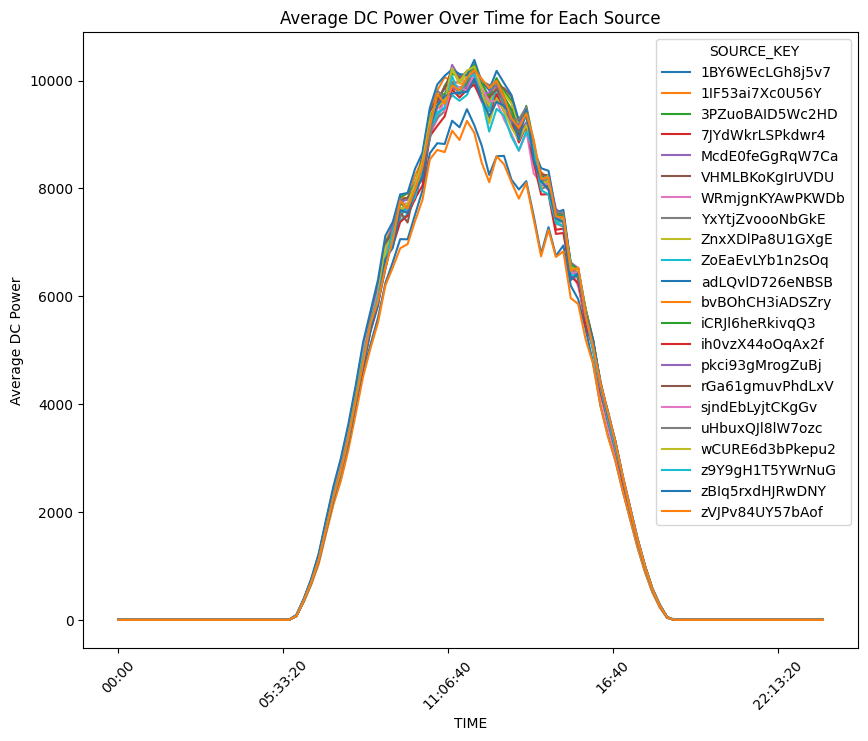

In [69]:
grouped_df = merged_df.groupby(['TIME', 'SOURCE_KEY'])['DC_POWER'].mean().unstack()
source_key_averages = merged_df.groupby('SOURCE_KEY')['DC_POWER'].mean()
below_average_source_keys = source_key_averages[source_key_averages < merged_df['DC_POWER'].mean()].sort_values()
print(f'Under performing inverters:{below_average_source_keys}')

grouped_df.plot(figsize=(10,8))
plt.xlabel('TIME')
plt.ylabel('Average DC Power')
plt.title('Average DC Power Over Time for Each Source')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

bvBOhCH3iADSZry, 1BY6WEcLGh8j5v7 inverters clearly under performing as we see on graph.

# FORCASTING


## Model Selection
You can use different models depending on the complexity and nature of your data:

Time Series Models:
ARIMA/SARIMA: These are classical time series forecasting models that work well if your data shows clear seasonal patterns.
Prophet: Developed by Facebook, this is a user-friendly model for forecasting that handles seasonality and trends.

Machine Learning Models:
Random Forest or Gradient Boosting (XGBoost, LightGBM): Suitable for capturing non-linear relationships between features like irradiance, weather, and solar power output.

Neural Networks (LSTM/RNN): These can capture long-term dependencies in time series data, making them ideal for more complex datasets with irregular patterns.

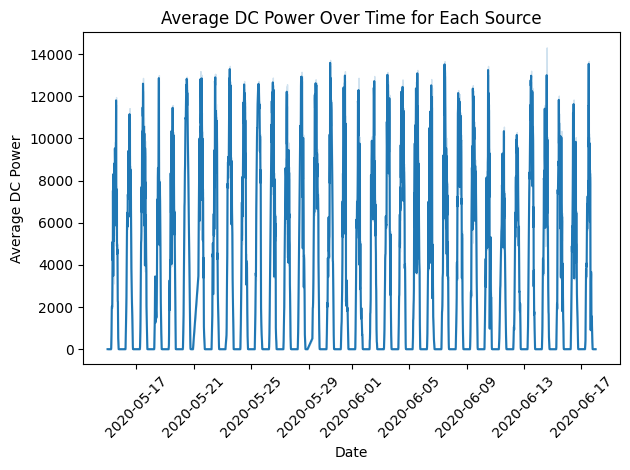

In [70]:
sns.lineplot(data=merged_df, x='DATE_TIME', y='DC_POWER')

plt.xlabel('Date')
plt.ylabel('Average DC Power')
plt.title('Average DC Power Over Time for Each Source')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

 
plt.show()


As we see clearly on the graphic we have seasonality, so we can use time-series forecasting models.

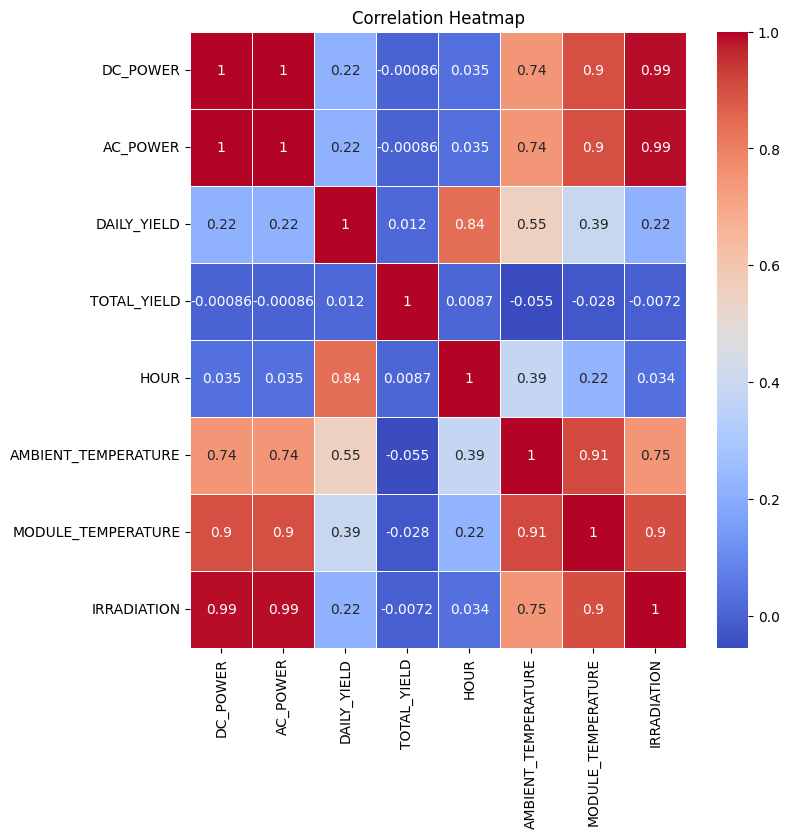

In [71]:
corr_matrix = merged_df.select_dtypes(include='number')

plt.figure(dpi=100, figsize=(8,8))
sns.heatmap(data=corr_matrix.corr(method='spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Facebook Prophet

## Split Train / Test DATA

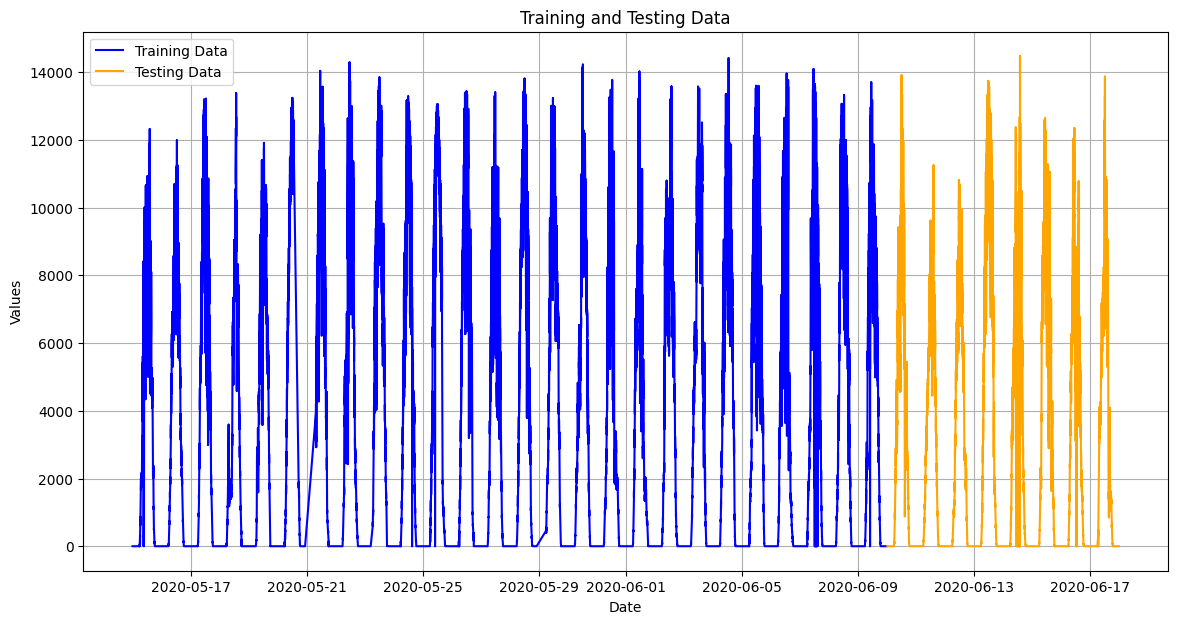

In [72]:
merged_df.set_index('DATE_TIME', inplace=True)

split = '2020-06-10 00:00:00'


train = merged_df[merged_df.index < split].copy()
test = merged_df[merged_df.index > split].copy()

# Plotting
plt.figure(figsize=(14, 7))  # Set the size of the plot
plt.plot(train.index, train['DC_POWER'], label='Training Data', color='blue')
plt.plot(test.index, test['DC_POWER'], label='Testing Data', color='orange')

# Adding titles and labels
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()  # Show the legend
plt.grid()    # Add a grid for better readability
plt.show()    # Display the plot

In [73]:
train_prophet = train.reset_index() \
    .rename(columns={'DATE_TIME' : 'ds',
                     'DC_POWER': 'y'})

In [74]:

model = Prophet()
model.fit(train_prophet)

14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
test_prophet = test.reset_index() \
    .rename(columns={'DATE_TIME' : 'ds',
                     'DC_POWER': 'y'})

test_frcst = model.predict(test_prophet)

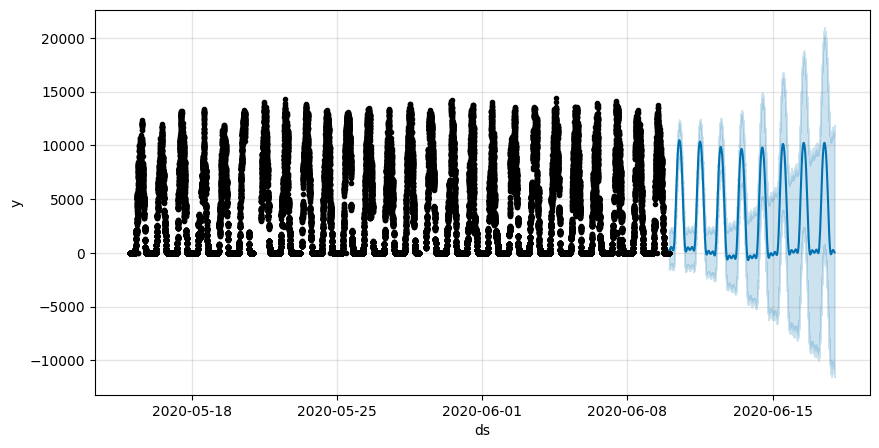

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_frcst, ax=ax)
plt.show()

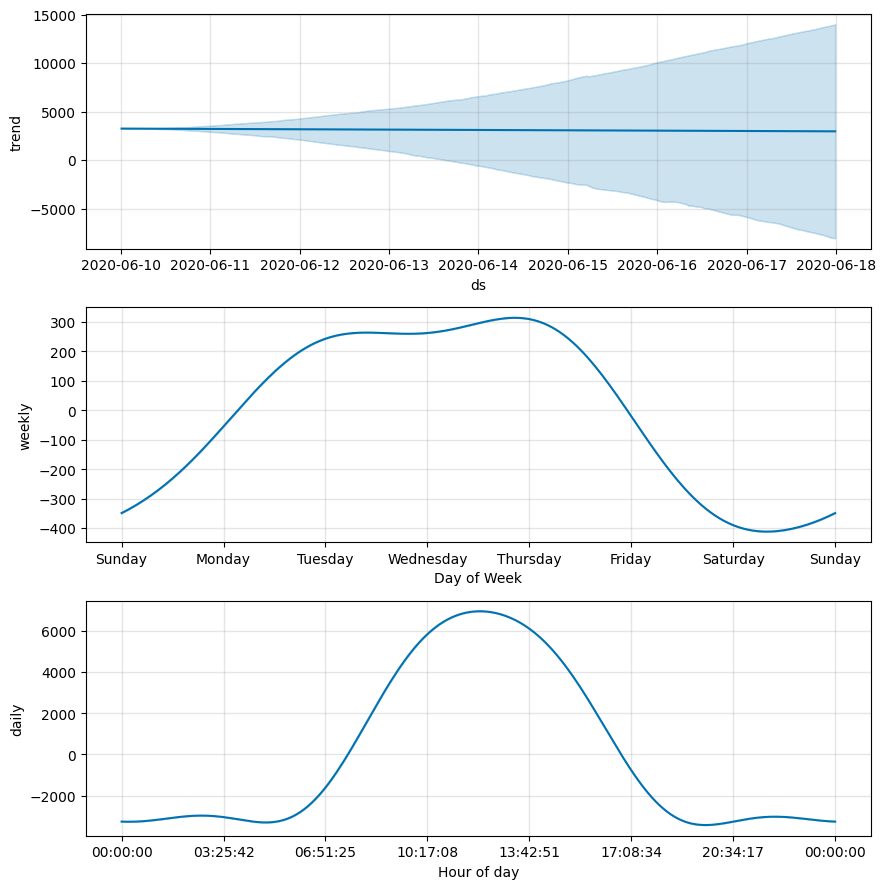

In [77]:
fig = model.plot_components(test_frcst) # type: ignore
plt.show()

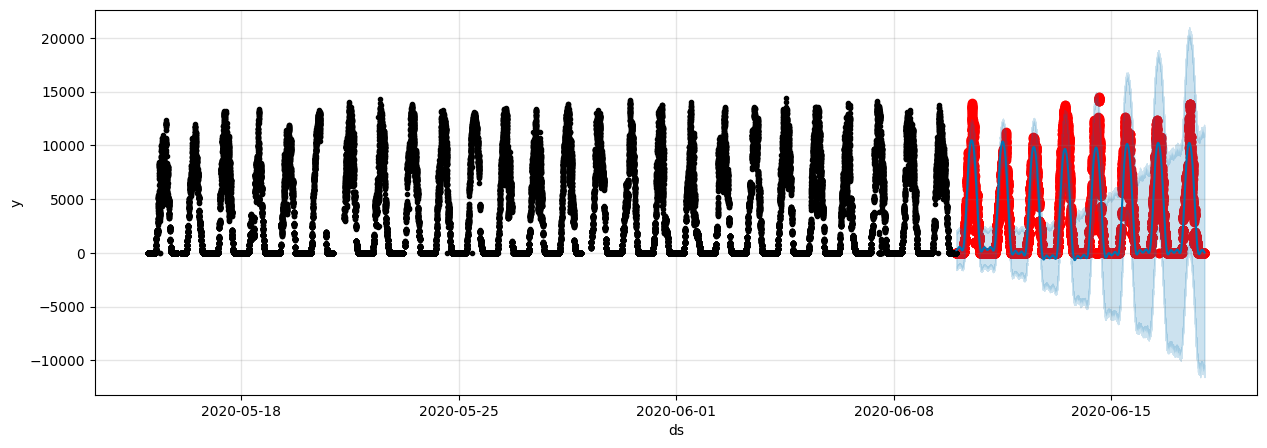

In [78]:
f, ax = plt.subplots(figsize= (15,5))

ax.scatter(test.index, test['DC_POWER'], color= 'red')
fig = model.plot(test_frcst, ax=ax)
plt.show()

In [138]:
rmse = np.sqrt(mean_squared_error(y_true= test_prophet['y'], y_pred=test_frcst['yhat']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1512.748865487333


In [141]:
mae = mean_absolute_error(y_true= test_prophet['y'], y_pred=test_frcst['yhat'])
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 907.5098298304332


# XGBOOST

In [80]:
import xgboost as xgb

In [81]:
FEATURES = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'HOUR']
TARGET = ['DC_POWER']

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET] 

In [82]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50)     
reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:2926.17383	validation_1-rmse:2639.05290
[1]	validation_0-rmse:2084.52953	validation_1-rmse:1901.43530
[2]	validation_0-rmse:1508.45122	validation_1-rmse:1394.13822
[3]	validation_0-rmse:1121.19192	validation_1-rmse:1053.91881
[4]	validation_0-rmse:869.54378	validation_1-rmse:831.82851
[5]	validation_0-rmse:712.69006	validation_1-rmse:693.94009
[6]	validation_0-rmse:620.61986	validation_1-rmse:611.26386
[7]	validation_0-rmse:568.23344	validation_1-rmse:562.27393
[8]	validation_0-rmse:539.51591	validation_1-rmse:535.42195
[9]	validation_0-rmse:523.57234	validation_1-rmse:521.23203
[10]	validation_0-rmse:515.02194	validation_1-rmse:513.85443
[11]	validation_0-rmse:509.37446	validation_1-rmse:509.52515
[12]	validation_0-rmse:506.42449	validation_1-rmse:507.39540
[13]	validation_0-rmse:503.59810	validation_1-rmse:506.24385
[14]	validation_0-rmse:501.11757	validation_1-rmse:504.84473
[15]	validation_0-rmse:497.40334	validation_1-rmse:506.29387
[16]	validation_0-rmse:496

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [83]:
y_pred = reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 504.8447275914391


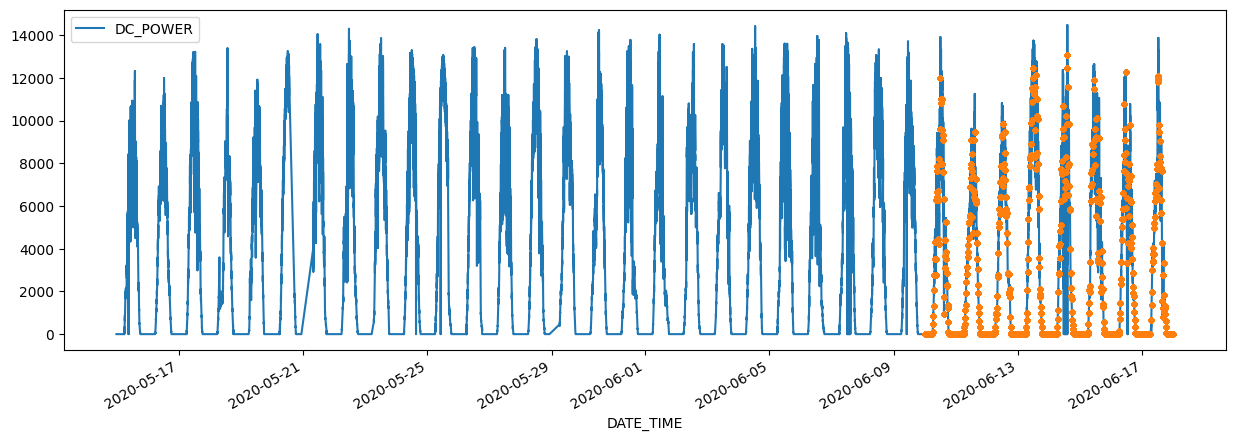

In [127]:
test['prediction']= reg.predict(x_test)
df = merged_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['DC_POWER']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.show()


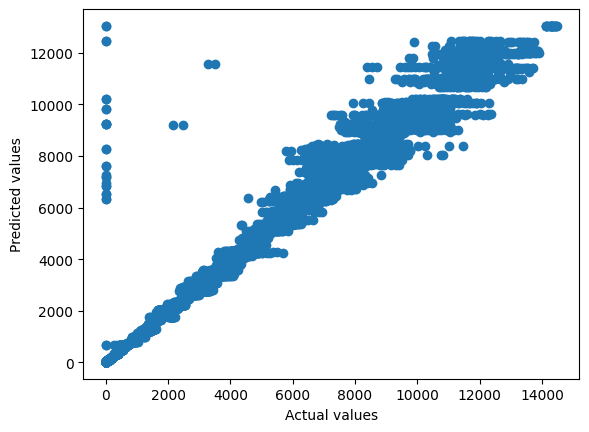

In [123]:

plt.scatter(y_test, y_pred)
plt.plot()  # Perfect prediction line
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()
